In [18]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import datetime
import scipy 
from scipy import optimize
import scipy.signal as signal 
import sys
sys.path.append("../")
from detect_peaks import detect_peaks
import quaternion as quat


from azure.storage.blob import BlockBlobService
import requests
import json
# sns.set(style="darkgrid")
download_dir =  "../G9_data/Downloaded"
# if not os.path.exists(download_dir):
#     os.mkdir(download_dir)
label_dict = {1:'walking',
             2:'walking upstairs',
             3:'walking downstairs',
             4:'sitting',
             5:'standing',
             6:'laying',
             7:'unknown'}

In [19]:
# Trained Model
df_model = pd.read_csv("../modelbuilding/data/preprocessed/data.csv", index_col=0)
df_model.dropna(axis=0, how='any', inplace=True)

In [20]:
np.unique(df_model['subject_id'])

array([ 1.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.])

In [21]:

X_training = df_model[df_model.columns[:-2]].values
y_training = df_model['label'].values

In [22]:
logreg = LogisticRegression()
logreg.fit(X_training, y_training)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
interested_cols = [ 'AccX', 'AccY', 'AccZ', 'GyroX','GyroY', 'GyroZ']
def create_datetime_index(df):
    # convert unix time to german time and then to date
    df['date'] = pd.to_datetime(df['system_time'],unit='ms')
    # set datetime index
    df.index = pd.DatetimeIndex(df["date"])
    df = df.drop(labels=["date"],  axis=1)
    return df
def read_file(path):
    df = pd.read_csv(path)
    return df
def get_sensor_data(df):

    df = create_datetime_index(df)
    df.sort_index(ascending = True, inplace = True)

    # Sensor Selection
    df_acc = df[df['sensor_name']=='Accelerometer']
    df_gyro = df[df['sensor_name']=='Gyroscope']

    # Merge accelerometer and gyroscope dataframes
    df_merged = pd.merge(df_acc, df_gyro, left_index=True, right_index= True, how='inner')
    df_merged.drop([
     'sensor_name_x',
     'value_x',
     'id_y',
     'sensor_name_y',
     'system_time_y',
     'value_y'], axis = 1, inplace = True)

    # Drop duplicates
    df_merged = df_merged.loc[::2] # run ony once

    # new column names
    df_merged.columns = ['id','system_time', 'AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
    df_merged.sort_index(ascending = True, inplace=True)
    return df_merged
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
def extract_energy_variables(f, psdX):
    
    i_low = find_nearest(f,4.0)
    i_high = find_nearest(f,7.0)
    
    energy_total = np.sum(psdX) 
    energy_interested = np.sum(psdX[i_low : i_high + 1]) 
    max_total = np.max(psdX)
    max_interested = np.max(psdX[i_low : i_high + 1])
    return energy_total,energy_interested, max_total, max_interested
def average_over_axis(df):
    aoa = df[interested_cols].mean(axis = 0)
    aoa.index += '_aoa'
    return aoa
def average_time_elapse(df):
    list_= []
    for col in interested_cols:
        a = df[col].values
        mph = a.mean()
        ind = detect_peaks(a, mph = mph, mpd=10, show=False)
        list_.append(np.diff(ind).mean())
    ate = pd.Series(list_, index=interested_cols)
    ate.index += '_ate'
    ate[pd.isnull(ate)]=0 #### TODO
    return ate
def average_peak_freq(df):
    list_f= []
    for col in interested_cols:
        a = df[col].values
        mph = a.mean()
        ind = detect_peaks(a, mph = mph, mpd=10, show=False)
        list_f.append(len(ind)/a.shape[0])
    apf = pd.Series(list_f, index=interested_cols)
    apf.index += '_apf'
    return apf
def rms_func(df):
    list_= []
    for col in interested_cols:
        a = df[col].values
        rms_temp = np.sqrt(np.mean(a**2))
        list_.append(rms_temp)
    rms = pd.Series(list_, index=interested_cols)
    rms.index += '_rms'
    return rms
def std_func(df):
    list_= []
    for col in interested_cols:
        a = df[col].values
        std_temp = np.std(a)
        list_.append(std_temp)
    std = pd.Series(list_, index=interested_cols)
    std.index += '_std'
    return std
def minmax_func(df):
    list_= []
    for col in interested_cols:
        a = df[col].values
        minmax_temp = np.max(a)-np.min(a)
        list_.append(minmax_temp)
    minmax = pd.Series(list_, index=interested_cols)
    minmax.index += '_minmax'
    return minmax
def cor_func(df):
    a = df[interested_cols[:3]].corr()
    b= df[interested_cols[3:]].corr()
    indexes = ['CorAccXAccY','CorAccXAccZ','CorAccYAccZ', 'CorGyroXGyroY','CorGyroXGyroZ','CorGyroYGyroZ']
    Cor = (a['AccX'][1:]).append(a['AccY'][2:]).append((b['GyroX'][1:]).append(b['GyroY'][2:]))
    Cor[pd.isnull(Cor)]=0 ### TODO
    corr = pd.Series(Cor.values, indexes)
    corr.index += '_corr'
    return corr
def get_all_features(df, file):
    
    aoa = average_over_axis(df)
    ate = average_time_elapse(df)
    apf = average_peak_freq(df)
    rms = rms_func(df)
    std = std_func(df)
    minmax = minmax_func(df)
    cor = cor_func(df)
    ser_list = [aoa, ate,apf, rms,std, minmax, cor]
    ser = pd.concat(ser_list)
    ser.name = file
    return ser

In [24]:
#Content is coherent with: https://pdfs.semanticscholar.org/7fa5/eebe34cd2efc0b48eb60fb62fbd0bb5f33ba.pdf
    #In line (20) of the paper, only one step of gradient descent is performed. In this function, maximally ten steps are taken
    
    #Input:
        #Window of signals (pandas df)
        #samplerate: samplerate (Default: 62.5 Hz)
        #alpha: parameter alpha according to (22) (Default: 1.1; needs to be adapted for each watch)
        #beta: parameter beta according to (33) (Default: 0.026266837793051865 for Microsoft Band 2)

    #Output:
        #Numpy array q_est containing the estimated rotation quaternions for each sample number (not depending on time) 

def do_pose_estimation(window, samplerate = 62.5, alpha = 1.1, beta = 0.026266837793051865):
    
    #dependencies
    import quaternion as quat
    from scipy import optimize
    import time
    
    starttime = time.time()
    
    'HELPER FUNCTIONS ##########################################################################################################'
    #Function that normalizes a quaternion
    def quat_normalize(q):
        return np.divide(q, np.absolute(q))
    
    #Function that converts a quaternion into a 4 dimensional numpy array
    def quat_as_array(q):
        return quat.as_float_array(q)
    
    #Quaternion derivative according to (3)
    def quat_der(t, q_est, gyr_quat):
        return 1/2 * np.multiply(quat_normalize(q_est[t-1]), gyr_quat[t])
    
    #Pose Estimation according to gyro integration according to (4)
    def q_omega(t, q_est, gyr_quat, delta_t):
        return np.add(quat_normalize(q_est[t-1]), quat_der(t, q_est, gyr_quat) * delta_t[t-1])
    
    #Definition of vector valued objective function f_g for gravity based pose estimation according to (12) 
    def f_g(q, s):
        return np.array([2*(q[1]*q[3] - q[0]*q[2]) - s[1],
                         2*(q[0]*q[1] + q[2]*q[3]) - s[2],
                         2*(1/2 - q[1]**2 - q[2]**2) - s[3]])
    
    #Jacobian matrix of objective function f_g according to (13)
    def J_g(q):
        return np.array([[-2*q[2], 2*q[3], -2*q[0], 2*q[1]], 
                         [2*q[1], 2*q[0], 2*q[3], 2*q[2]], 
                         [0, -4*q[1], -4*q[2], 0]])
    
    #Gradient of scalar valued objective function f according to (21)
    def grad_f(q, s):
        #Dot product is row wise and works like matrix product
        return np.transpose(J_g(q)).dot(f_g(q, s))
    
    #Mu according to (22)
    def mu(t, q_est, gyr_quat, delta_t):
        return alpha * np.absolute(quat_der(t, q_est, gyr_quat)) * delta_t[t]
    
    #Gravity based pose estimation resulting from full gradient descent (adapted from (20)) 
    def q_nabla(t, q_est, acc_quat):
        s = quat_as_array(acc_quat[t])
        q_0 = quat_as_array(q_est[t-1])
        #Objective function depending on only one input parameter for optimization
        def func(q):
            return 1/2 * np.linalg.norm(f_g(q, s))**2
        #Gradient of objective function depending on only one input parameter for optimization 
        def grad_func(q):
            return grad_f(q, s)
        return quat.as_quat_array(scipy.optimize.minimize(fun = func, x0 = q_0, jac = grad_func, options={'maxiter': 10}).x)
    
    #Gamma according to (25) 
    def gamma(t, q_est, gyr_quat, delta_t):
        return beta / ((mu(t, q_est, gyr_quat, delta_t)/delta_t[t]) + beta)
    
    #Pose estimation quaternion according to (23)
    def q_estimate(t, q_est, acc_quat, gyr_quat, delta_t):
        gamma_t = gamma(t, q_est, gyr_quat, delta_t)
        return gamma_t * q_nabla(t, q_est, acc_quat) + (1 - gamma_t) * q_omega(t, q_est, gyr_quat, delta_t)
    '###########################################################################################################################'
    
    acc = window[interested_cols[:3]]
    gyr = window[interested_cols[3:]]
    
    #Data size for variable size definitions
    nrows = acc.shape[0]
    ncols = acc.shape[1]
    
    #Convert gyroscope data to quaternions according to (1): gyr_quat
    gyr_quat = np.zeros((nrows, ncols + 1))
    gyr_quat[:, range(1, ncols + 1)] = gyr
    gyr_quat = quat.as_quat_array(gyr_quat)

    #Generate accelerometer data quaternion according to (11): acc_quat
    acc_quat = np.zeros((nrows, ncols + 1))
    acc_quat[:, range(1, ncols + 1)] = acc
    acc_quat = quat.as_quat_array(acc_quat)
    
    #delta_t vector for time between timestamps
    'Current version: Assume constant delta_t. May be adapted in the future.'
    delta_t = (1/samplerate) * np.ones(nrows)

    #Initialize empty numpy Array containing pose estimation quaternions 
    q_est = quat.as_quat_array(np.zeros((nrows, ncols + 1)))

    #First estimate of rotation quaternion: Rotation of 0° around the axis defined by [0, 0, 1], i. e., no rotation
    q_0 = quat.from_rotation_matrix(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]))
    q_est[0] = q_0
    
    #Run pose estimation algorithm and save all estimated quaternions in q_est 
    for t in range(1,nrows):
        q_est[t] = q_estimate(t, q_est, acc_quat, gyr_quat, delta_t)
    
    endtime = time.time()
    print('Pose esimation finished! Elapsed time:', time.strftime("%H:%M:%S", time.gmtime(endtime - starttime)))
        
    return np.degrees(quat.as_euler_angles(q_est))
#quat.as_float_array(q_est) #euler angles as possible further output: euler = np.degrees(quat.as_euler_angles(q_est))

In [25]:
def time_to_str(t):
    t_woM = t.replace(microsecond=0)

    dt64 = np.datetime64(t_woM)
    dt64

    a = dt64.astype('datetime64[s]')

    return np.datetime_as_string(a)+"Z"

In [26]:
block_blob_service = BlockBlobService(account_name='watchstorage', account_key='TJWcjsCs4aK9Xorw4DIAZGvKz0AFb2kvgSh49t+3nADR2usZ1ED14GLBQ/klJsSSrKykxu0ghCXn46+0bv2J8Q==')

container_name = 'jnj'
generator = block_blob_service.list_blobs(container_name)

# Download each day movement data 
for blob in generator:
    print("\t Blob name: " + blob.name)
    if not os.path.exists(os.path.join(download_dir, blob.name)) : # check filecmp.cmp()
        if not os.path.exists(os.path.join(download_dir, blob.name.split('/')[0])):
            os.mkdir(os.path.join(download_dir, blob.name.split('/')[0]))
        print("downloading...")
        block_blob_service.get_blob_to_path(container_name, blob.name,os.path.join(download_dir, blob.name ))
        print("downloaded")
    else:
        print("Already downloaded ")

	 Blob name: 2017-11-29/861452078_35dbed8e8c614be8aebdb5b5dbfee0d3_1.csv
Already downloaded 
	 Blob name: 2017-11-29/861452078_675bc4bf31d94968974e58c2a18f7519_1.csv
Already downloaded 
	 Blob name: 2017-11-30/873240569_c3066418061948fdbc1f1fdcde734e65_1.csv
Already downloaded 
	 Blob name: 2017-12-05/873240569_6644c7aa2d104486b60aa0428b6e5dce_1.csv
Already downloaded 
	 Blob name: 2017-12-06/873240569_34f3bf5800304afba5659dd3fe4ea167_1.csv
Already downloaded 
	 Blob name: 2017-12-07/873240569_4cd837cbf09141be8211a802db1b649b_1.csv
Already downloaded 
	 Blob name: 2017-12-08/873240569_3a862ff4cf5c40f08c26524da382e227_1.csv
Already downloaded 
	 Blob name: 2017-12-11/873240569_231439354b5a46ada32e77abee3ddbba_1.csv
Already downloaded 
	 Blob name: 2017-12-12/873240569_075dc9e3d8ea4e9b8647d834e571f15e_1.csv
Already downloaded 
	 Blob name: 2017-12-13/873240569_b4a0e0c810ae426aac376cefacb78ec8_1.csv
Already downloaded 
	 Blob name: 2017-12-14/873240569_d50457a7bb9b4e43bf5033eb8a9ac439_1.c

In [27]:
from datetime import date, timedelta
yesterday = date.today() - timedelta(1)
yesterday = yesterday.strftime('%Y-%m-%d')
today = date.today().strftime('%Y-%m-%d')
dates_to_consider = [(date.today() - timedelta(i)).strftime('%Y-%m-%d') for i in range(0,6)]
print(yesterday)
print(today)

2018-02-28
2018-03-01


In [28]:
df_list = []
for day in dates_to_consider:
    path = os.path.join(download_dir, day)
    if os.path.exists(path):
        for root,dirs,files in os.walk(path):
            if files[0].endswith(".csv"):
                file_path = path+'/'+files[0]
                df_list.append(pd.read_csv(file_path))
df = pd.concat(df_list)

In [29]:
df.head()

,id,system_time,sensor_name,x,y,z,value
0,watch-sensor-356969030512673,1519873288523,Accelerometer,0.330400,0.095768,9.342175,NaN
1,watch-sensor-356969030512673,1519873288551,Accelerometer,0.335188,0.105345,9.294291,NaN
2,watch-sensor-356969030512673,1519873288566,Accelerometer,0.325611,0.095768,9.346964,NaN
3,watch-sensor-356969030512673,1519873288586,Accelerometer,0.311246,0.114922,9.303867,NaN
4,watch-sensor-356969030512673,1519873288638,Accelerometer,0.344765,0.090980,9.313444,NaN


In [33]:
 for x in list(df['id'].unique()):
        print(x)

watch-sensor-356969030512673
watch-sensor-356969030312710
watch-sensor-356969030312827
watch-sensor-356969030312769
watch-sensor-356969030312660


('Watch ', 'watch-sensor-356969030512673', ' is being processed')


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


('doing time:', Timestamp('2018-02-28 16:00:00'), ' - ', Timestamp('2018-02-28 16:05:00'))
('doing time:', Timestamp('2018-02-28 16:05:00'), ' - ', Timestamp('2018-02-28 16:10:00'))
('doing time:', Timestamp('2018-02-28 16:10:00'), ' - ', Timestamp('2018-02-28 16:15:00'))
('doing time:', Timestamp('2018-02-28 16:15:00'), ' - ', Timestamp('2018-02-28 16:20:00'))
('doing time:', Timestamp('2018-02-28 16:20:00'), ' - ', Timestamp('2018-02-28 16:25:00'))
('doing time:', Timestamp('2018-02-28 16:25:00'), ' - ', Timestamp('2018-02-28 16:30:00'))
('doing time:', Timestamp('2018-02-28 16:30:00'), ' - ', Timestamp('2018-02-28 16:35:00'))
('doing time:', Timestamp('2018-02-28 16:35:00'), ' - ', Timestamp('2018-02-28 16:40:00'))
('doing time:', Timestamp('2018-02-28 16:40:00'), ' - ', Timestamp('2018-02-28 16:45:00'))
('doing time:', Timestamp('2018-02-28 16:45:00'), ' - ', Timestamp('2018-02-28 16:50:00'))
('doing time:', Timestamp('2018-02-28 16:50:00'), ' - ', Timestamp('2018-02-28 16:55:00'))

('doing time:', Timestamp('2018-02-28 23:35:00'), ' - ', Timestamp('2018-02-28 23:40:00'))
('doing time:', Timestamp('2018-02-28 23:40:00'), ' - ', Timestamp('2018-02-28 23:45:00'))
('doing time:', Timestamp('2018-02-28 23:45:00'), ' - ', Timestamp('2018-02-28 23:50:00'))
('doing time:', Timestamp('2018-02-28 23:50:00'), ' - ', Timestamp('2018-02-28 23:55:00'))
('doing time:', Timestamp('2018-02-28 23:55:00'), ' - ', Timestamp('2018-03-01 00:00:00'))
('doing time:', Timestamp('2018-03-01 00:00:00'), ' - ', Timestamp('2018-03-01 00:05:00'))
('doing time:', Timestamp('2018-03-01 00:05:00'), ' - ', Timestamp('2018-03-01 00:10:00'))


NameError: global name 'detect_peaks' is not defined

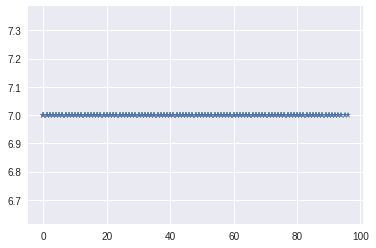

In [16]:
for watch_id in [df['id'].unique():
    #TODO: Select all watches and do the predictions
    print("Watch ", watch_id," is being processed" )
    df_temp = get_sensor_data(df)
    # TODO: Select Sensor name
    df_temp = df_temp[df_temp['id']==watch_id]
    df_temp.sort_index(ascending = True, inplace = True)
    # Time to do analysis is specified
    start = yesterday + 'T16:00:00.0000Z'
    start_temp = np.datetime64(start)
    t = pd.Timestamp(start_temp)
    end = today + 'T16:00:00.0000Z'
    end_temp = np.datetime64(end)
    end_time = pd.Timestamp(end_temp)
    
    # Initialize 
    whole_window_size = datetime.timedelta(minutes = 5)
    window_size = datetime.timedelta(seconds=2)
    window_slide = datetime.timedelta(seconds=1)
    samples_count = []
    a = 0
    df_out = pd.DataFrame()
    t_start_list = []
    t_end_list = []
    outcome_list = []
    while (t + whole_window_size < end_time):
        label_list = []
        increment = 0
        DF = pd.DataFrame()
        t_end5min= t + whole_window_size 
        print("doing time:",t, ' - ', t_end5min)
        t_start_list.append(time_to_str(t))
        t_end_list.append(time_to_str(t_end5min))
        while(t+window_slide< t_end5min):
            t_end = t + window_size
            snippet_df = df_temp.between_time(t.to_pydatetime().time(), t_end.to_pydatetime().time()
                                           ,include_start=True, include_end=False)
            if snippet_df.shape[0]>= 20:
                increment +=1
                ser = get_all_features(snippet_df, increment)
                ser = ser.round(4)
                DF = DF.append(ser, verify_integrity=True)
            t = t_end
        #DF.dropna(axis=0, how='any', inplace=True)
        DF = DF.fillna(DF.mean())
        if DF.shape[0]<=11:
            outcome = 7.0
        else:
            X_test = DF.values
            y_pred = logreg.predict(X_test)                
            u, c = np.unique(y_pred, return_counts=True)
            outcome = u[np.argmax(c)]
        outcome_list.append(label_dict[int(outcome)])
        out_ser = pd.Series(outcome,name=(t-whole_window_size, t) )
        df_out = df_out.append(out_ser)
        plt.plot(list(range(df_out.shape[0])), df_out[0], "*")
        
        ## Send predictions 
    plt.show()   
    dict_list = []
    for i in range(len(outcome_list)):
        payload_dict = {'address':watch_id.split("-")[2],
             'starttime':t_start_list[i],
             'endtime':t_end_list[i],
             'tasklocation':'Activity',
             'taskname':outcome_list[i],
             'name':outcome_list[i],
             'value':1}
        dict_list.append(payload_dict)
    payload = json.dumps(dict_list)
    url = "https://colife-dashboard.silverline.mobi/uploadActivityLabelForSmartWatch"
    headers = {
        'content-type': "application/json",
        'cache-control': "no-cache",
        'postman-token': "87b2b04f-175f-4a9b-f2c8-bf31de2cae7d"
        }

    response = requests.request("POST", url, data=payload, headers=headers)
    print(response.text)

